In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense,GlobalAveragePooling2D, Input
from keras.optimizers import SGD, RMSprop, Adam
from keras.models import Model
from keras.layers.normalization import BatchNormalization


from keras.callbacks import ModelCheckpoint, EarlyStopping

from time import time

import matplotlib.pyplot as plt

np.random.seed(617)

/home/danielchan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def vgg16_model():
    from keras.applications.vgg16 import VGG16
    from keras.applications.vgg16 import preprocess_input
    img_width, img_height = 224,224
    print ('using the VGG16 model')
    input_shape=(img_width, img_height, 3)
    img_input = Input(shape=input_shape)
    base_model = VGG16(include_top=False, weights='imagenet', input_tensor=img_input)
    print('VGG16 model loaded')
    return base_model, img_width, img_height, preprocess_input

In [3]:
def resnet50_model():
    from keras.applications.resnet50 import ResNet50
    from keras.applications.resnet50 import preprocess_input
    img_width, img_height = 224,224
    print ('using the ResNet50 model')
    input_shape=(img_width, img_height, 3)
    img_input = Input(shape=input_shape)
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=img_input)
    print('ResNet50 model loaded')
    return base_model, img_width, img_height, preprocess_input

Let find out which version of Keras we are running

In [4]:
import keras

print(keras.__version__)

2.2.0


In [5]:
def history_plot(history, save=False):

    %matplotlib inline

#_, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.subplots_adjust(wspace=0.4)

    #fig.tight_layout(w_pad=2.0)
    ax1.plot(history.history['acc'])
    ax1.plot(history.history['val_acc'])
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'validation'], loc='lower right')

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'validation'], loc='upper right')

    plt.show()
    if (save): fig.savefig('history_plot_ResNet50_0.01.jpeg',dpi=600)

    return


In [6]:
def load_model(Top_load=False, Big_load=False):
# dimensions of our images.

   num_class = 10
   base_model, img_width, img_height, preprocess_input=resnet50_model()

# build a classifier model to put on top of the convolutional model

   top_model = Sequential()
   top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
   top_model.add(Dense(1024, activation='relu'))
   top_model.add(BatchNormalization())
#   top_model.add(Dense(1024, activation='relu'))
#   top_model.add(BatchNormalization())
   top_model.add(Dense(num_class, activation='softmax'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning

   if (Top_load):
        top_model.load_weights("ResNet50_top_model_weights.h5")
        print ("loaded the weights for top layers")
   

   model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

   if (Big_load):
        model.load_weights("weights.best.hdf5")
        print ("loaded the weights for the entire model")
       

   return model,img_width, img_height,preprocess_input



In [7]:
from clr_callback import CyclicLR
from lr_finder import LRFinder
from sgdr import SGDRScheduler

In [8]:

def train_model(nb_batch=32,epochs=10,lr=1.e-6, 
                start_layer=15, Top_load=False, Big_load=False, CLR=True):

   nb_epoch = epochs
   batch_train = nb_batch
   batch_valid = nb_batch

   model,img_width,img_height,preprocess_input = load_model(Top_load=Top_load,
                                                            Big_load=Big_load)

   for layer in model.layers:
       layer.trainable = False

   for layer in model.layers[start_layer:]:
      layer.trainable = True

   for i, layer in enumerate(model.layers):
      print(i, layer.name, layer.trainable)


   model.compile(optimizer=SGD(lr=lr,momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy']) 

   train_data_dir='/home/danielchan/Downloads/cifar/train'
   validation_data_dir='/home/danielchan/Downloads/cifar/test'

#define preprocessing function
#
#convert images from RGB to BGR so we can use the weights from Caffe simulation    

   datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
  

   train_generator = datagen.flow_from_directory(
            train_data_dir,
            target_size=(img_width, img_height),
            class_mode='categorical',
            batch_size=batch_train,
            shuffle=True)

   valid_generator = datagen.flow_from_directory(
            validation_data_dir,
            target_size=(img_width, img_height),
            class_mode='categorical',
            batch_size=batch_valid,
            shuffle=False)

   
   nb_train_samples = len(train_generator.classes)
   nb_validation_samples = len(valid_generator.classes)
    
   train_size = np.int( np.ceil(nb_train_samples/batch_train) )
   valid_size = np.int( np.ceil(nb_validation_samples/batch_valid) )

   print(nb_train_samples,nb_validation_samples,train_size,valid_size)



# checkpoint

   callbacks_list = []
    
   filepath="weights.best"+".hdf5"
   checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                                save_best_only=True, mode='auto')
   callbacks_list.append(checkpoint)

   earlystop = EarlyStopping(monitor='val_acc', min_delta=0.01, patience=5, \
                          verbose=1, mode='auto')    
   #callbacks_list.append(earlystop) 
    
   clr = CyclicLR(base_lr=1.e-4, max_lr=0.01,
                       step_size=np.int(1*np.ceil(nb_train_samples/batch_train)), 
                       mode='triangular')
   callbacks_list.append(clr) 


   history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_size,
        epochs=nb_epoch,
        verbose=2,
        validation_data=valid_generator,
        validation_steps=valid_size,callbacks=callbacks_list)

   return history,model


In [9]:
start = time()
history,model=train_model(nb_batch=32,epochs=50,start_layer=1,Top_load=False, Big_load=False)
print ('time to train the model: ',time()-start)

using the ResNet50 model
ResNet50 model loaded
0 input_1 False
1 conv1_pad True
2 conv1 True
3 bn_conv1 True
4 activation_1 True
5 max_pooling2d_1 True
6 res2a_branch2a True
7 bn2a_branch2a True
8 activation_2 True
9 res2a_branch2b True
10 bn2a_branch2b True
11 activation_3 True
12 res2a_branch2c True
13 res2a_branch1 True
14 bn2a_branch2c True
15 bn2a_branch1 True
16 add_1 True
17 activation_4 True
18 res2b_branch2a True
19 bn2b_branch2a True
20 activation_5 True
21 res2b_branch2b True
22 bn2b_branch2b True
23 activation_6 True
24 res2b_branch2c True
25 bn2b_branch2c True
26 add_2 True
27 activation_7 True
28 res2c_branch2a True
29 bn2c_branch2a True
30 activation_8 True
31 res2c_branch2b True
32 bn2c_branch2b True
33 activation_9 True
34 res2c_branch2c True
35 bn2c_branch2c True
36 add_3 True
37 activation_10 True
38 res3a_branch2a True
39 bn3a_branch2a True
40 activation_11 True
41 res3a_branch2b True
42 bn3a_branch2b True
43 activation_12 True
44 res3a_branch2c True
45 res3a_branch


Epoch 00031: val_loss did not improve from 0.14433
Epoch 32/50
 - 456s - loss: 0.0105 - acc: 0.9966 - val_loss: 0.2141 - val_acc: 0.9490

Epoch 00032: val_loss did not improve from 0.14433
Epoch 33/50
 - 451s - loss: 0.0025 - acc: 0.9993 - val_loss: 0.2284 - val_acc: 0.9491

Epoch 00033: val_loss did not improve from 0.14433
Epoch 34/50
 - 453s - loss: 0.0030 - acc: 0.9991 - val_loss: 0.2025 - val_acc: 0.9522

Epoch 00034: val_loss did not improve from 0.14433
Epoch 35/50
 - 453s - loss: 0.0019 - acc: 0.9995 - val_loss: 0.2577 - val_acc: 0.9433

Epoch 00035: val_loss did not improve from 0.14433
Epoch 36/50
 - 453s - loss: 0.0024 - acc: 0.9993 - val_loss: 0.2049 - val_acc: 0.9527

Epoch 00036: val_loss did not improve from 0.14433
Epoch 37/50
 - 453s - loss: 9.4359e-04 - acc: 0.9997 - val_loss: 0.2110 - val_acc: 0.9545

Epoch 00037: val_loss did not improve from 0.14433
Epoch 38/50
 - 449s - loss: 0.0011 - acc: 0.9996 - val_loss: 0.2152 - val_acc: 0.9528

Epoch 00038: val_loss did not

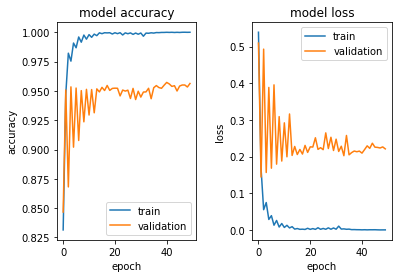

In [10]:
history_plot(history, save=True)

In [11]:
from keras.applications.resnet50 import preprocess_input

validation_data_dir='/home/danielchan/Downloads/cifar/test'
batch = 128
img_width, img_height = 224,224

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_generator = datagen.flow_from_directory(
            validation_data_dir,
            target_size=(img_width, img_height),
            class_mode='categorical',
            batch_size=batch,
            shuffle=False)
steps = np.int(np.ceil(len(valid_generator.classes)/batch))
num_valid = len(valid_generator.classes)
print (num_valid,steps)

Found 10000 images belonging to 10 classes.
10000 79


In [12]:
#loss = model.evaluate_generator(valid_generator, steps=steps)
#print (loss)

In [13]:
num_classes = 10
steps = np.int(steps)
probs  = np.zeros((0,num_classes))
labels = np.zeros((0,num_classes))
for step in range(steps):
    print('Proccessing Batch '+ str(step))
    x,label = valid_generator.next()
    preds=model.predict(x)
    probs=np.concatenate((probs,preds),axis=0)
    labels=np.concatenate((labels,label),axis=0)

Proccessing Batch 0
Proccessing Batch 1
Proccessing Batch 2
Proccessing Batch 3
Proccessing Batch 4
Proccessing Batch 5
Proccessing Batch 6
Proccessing Batch 7
Proccessing Batch 8
Proccessing Batch 9
Proccessing Batch 10
Proccessing Batch 11
Proccessing Batch 12
Proccessing Batch 13
Proccessing Batch 14
Proccessing Batch 15
Proccessing Batch 16
Proccessing Batch 17
Proccessing Batch 18
Proccessing Batch 19
Proccessing Batch 20
Proccessing Batch 21
Proccessing Batch 22
Proccessing Batch 23
Proccessing Batch 24
Proccessing Batch 25
Proccessing Batch 26
Proccessing Batch 27
Proccessing Batch 28
Proccessing Batch 29
Proccessing Batch 30
Proccessing Batch 31
Proccessing Batch 32
Proccessing Batch 33
Proccessing Batch 34
Proccessing Batch 35
Proccessing Batch 36
Proccessing Batch 37
Proccessing Batch 38
Proccessing Batch 39
Proccessing Batch 40
Proccessing Batch 41
Proccessing Batch 42
Proccessing Batch 43
Proccessing Batch 44
Proccessing Batch 45
Proccessing Batch 46
Proccessing Batch 47
Pr

In [14]:
validation_labels = np.argmax(labels[:,],axis=1)

#print (probs[:10,], np.argmax(probs[:10,],axis=1))
#print (validation_labels[:10])

0.9991394444444445


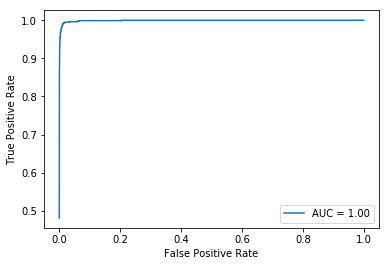

In [15]:

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(validation_labels, probs[:,0], 0)
roc_auc = auc(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot(fpr,tpr,label='AUC = %0.2f' % roc_auc)
plt.legend(loc="lower right")


print ( roc_auc)

0.9984215555555556


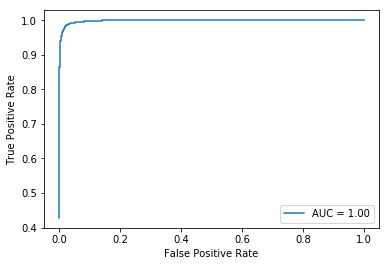

In [16]:
fpr, tpr, thresholds = roc_curve(validation_labels, probs[:,2], 2)
roc_auc = auc(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot(fpr,tpr,label='AUC = %0.2f' % roc_auc)
plt.legend(loc="lower right")
print ( roc_auc)

In [17]:
model.save_weights("ResNet50_finetune_model_weights.h5")